## Importing Libraries

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from DecisionTree import DecisionTree
from collections import Counter

## Data Preprocessing

In [3]:
#reading the csv
retail_csv = pd.read_csv("data/Online Retail Data Set.csv", encoding='unicode_escape')
retail_csv.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
#checking the data type, shape and overall description of the dataset 
retail_csv.info(), retail_csv.shape, retail_csv.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


(None,
 (541909, 8),
        InvoiceNo StockCode                         Description       Quantity  \
 count     541909    541909                              540455  541909.000000   
 unique     25900      4070                                4223            NaN   
 top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER            NaN   
 freq        1114      2313                                2369            NaN   
 mean         NaN       NaN                                 NaN       9.552250   
 std          NaN       NaN                                 NaN     218.081158   
 min          NaN       NaN                                 NaN  -80995.000000   
 25%          NaN       NaN                                 NaN       1.000000   
 50%          NaN       NaN                                 NaN       3.000000   
 75%          NaN       NaN                                 NaN      10.000000   
 max          NaN       NaN                                 NaN   80995.00000

In [5]:
#checking missing value per column
retail_csv.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

So, we can notice that:
- there are missing values in `Description` and `CustomerID` 
- `InvoiceDate` needs to be converted to date-time object
- `UnitPrice` and `Quantity` have negative values
- `CustomerID` can be a categorial variable

In [6]:
#Handling the missing values first by droping rows where Description or CustomerID is missing
retail_csv = retail_csv.dropna(subset=['Description','CustomerID'])
retail_csv.isnull().sum(), retail_csv.shape

(InvoiceNo      0
 StockCode      0
 Description    0
 Quantity       0
 InvoiceDate    0
 UnitPrice      0
 CustomerID     0
 Country        0
 dtype: int64,
 (406829, 8))

In [7]:
#Convert InvoiceDate column to date-time object
retail_csv['InvoiceDate'] = pd.to_datetime(retail_csv['InvoiceDate'], dayfirst='True')
retail_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [8]:
#Dealing with the negative value from UnitPrice and Quantity
retail_csv = retail_csv[(retail_csv['Quantity'] > 0) & (retail_csv['UnitPrice'] > 0)]
retail_csv.describe(include="all")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,397884,397884,397884,397884.000000,397884,397884.000000,397884.000000,397884
unique,18532,3665,3877,NaN,NaN,NaN,NaN,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,542,2035,2028,NaN,NaN,NaN,NaN,354321
mean,NaN,NaN,NaN,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453,NaN
min,NaN,NaN,NaN,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,NaN
25%,NaN,NaN,NaN,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,NaN
50%,NaN,NaN,NaN,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,NaN
75%,NaN,NaN,NaN,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,NaN


In [9]:
retail_csv['InvoiceNo'].value_counts(), retail_csv['StockCode'].value_counts(), retail_csv['CustomerID'].value_counts(), retail_csv['Country'].value_counts()

(InvoiceNo
 576339    542
 579196    533
 580727    529
 578270    442
 573576    435
          ... 
 556918      1
 556885      1
 544170      1
 556842      1
 575830      1
 Name: count, Length: 18532, dtype: int64,
 StockCode
 85123A    2035
 22423     1723
 85099B    1618
 84879     1408
 47566     1396
           ... 
 90168        1
 90169        1
 90202A       1
 90118        1
 23843        1
 Name: count, Length: 3665, dtype: int64,
 CustomerID
 17841.0    7847
 14911.0    5675
 14096.0    5111
 12748.0    4595
 14606.0    2700
            ... 
 18184.0       1
 13185.0       1
 16073.0       1
 17948.0       1
 17846.0       1
 Name: count, Length: 4338, dtype: int64,
 Country
 United Kingdom          354321
 Germany                   9040
 France                    8341
 EIRE                      7236
 Spain                     2484
 Netherlands               2359
 Belgium                   2031
 Switzerland               1841
 Portugal                  1462
 Australia    

Now, we will encode `InvoiceNo`, `StockCode`, `CustomerID`, `Country` as categorial variable

In [10]:
#Encoding the categorial variables
categorical_columns = ['InvoiceNo', 'StockCode', 'Description', 'Country']
label_encoders = {col:LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    retail_csv[col] = label_encoders[col].fit_transform(retail_csv[col])
    
#Feature scaling for UnitPrice and Quantity
# scaler = StandardScaler()
# retail_csv[['Quantity','UnitPrice']] = scaler.fit_transform(retail_csv[['Quantity','UnitPrice']])

#check the new data
retail_csv.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,3233,3698,6,2010-12-01 08:26:00,2.55,17850.0,35
1,0,2643,3706,6,2010-12-01 08:26:00,3.39,17850.0,35
2,0,2847,858,8,2010-12-01 08:26:00,2.75,17850.0,35
3,0,2795,1804,6,2010-12-01 08:26:00,3.39,17850.0,35
4,0,2794,2763,6,2010-12-01 08:26:00,3.39,17850.0,35
5,0,1601,2964,2,2010-12-01 08:26:00,7.65,17850.0,35
6,0,751,1435,6,2010-12-01 08:26:00,4.25,17850.0,35
7,1,1486,1553,6,2010-12-01 08:28:00,1.85,17850.0,35
8,1,1485,1550,6,2010-12-01 08:28:00,1.85,17850.0,35
9,2,3059,216,32,2010-12-01 08:34:00,1.69,13047.0,35


## Exploratory Data Analysis

In [11]:
#Let's see the summary of our preprocessed data
retail_summary = retail_csv.describe()
retail_null_check = retail_csv.isnull().sum()
print(retail_summary)
print(f"\nChecking for missing values in each column: \n{retail_null_check}")

           InvoiceNo      StockCode    Description       Quantity  \
count  397884.000000  397884.000000  397884.000000  397884.000000   
mean     9714.599672    1566.034540    2015.209516      12.988238   
min         0.000000       0.000000       0.000000       1.000000   
25%      4944.000000     932.000000    1135.000000       2.000000   
50%     10122.000000    1517.000000    1976.000000       6.000000   
75%     14411.000000    2102.000000    2934.000000      12.000000   
max     18531.000000    3664.000000    3876.000000   80995.000000   
std      5382.187153     840.420596    1084.913741     179.331775   

                         InvoiceDate      UnitPrice     CustomerID  \
count                         397884  397884.000000  397884.000000   
mean   2011-07-10 23:41:23.511023360       3.116488   15294.423453   
min              2010-12-01 08:26:00       0.001000   12346.000000   
25%              2011-04-07 11:12:00       1.250000   13969.000000   
50%              2011-07-31 

Some observation:
- `Quantity` and `UnitPrice` are properly scaled and has no negative value. but both have some outliers
- The categorial columns (`InvoiceNo`, `StockCode`, `Description`, `Country`) are encoded properly.
- has no missing values

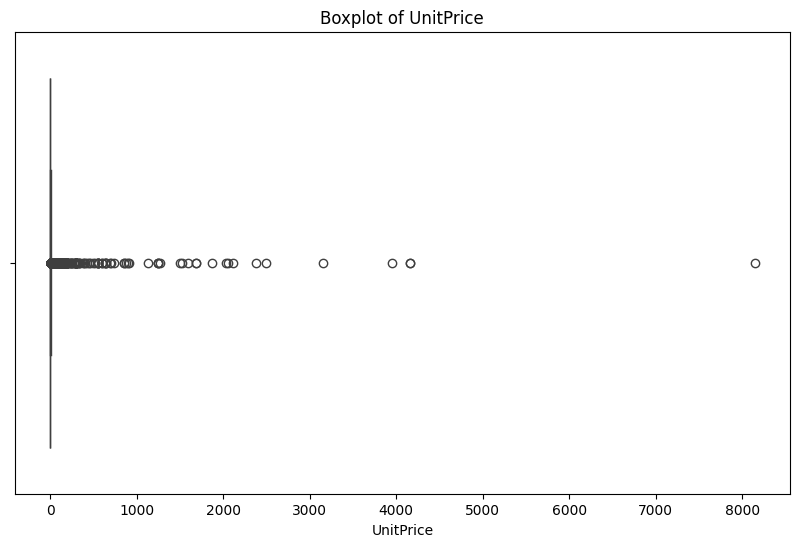

In [12]:
#Visualizing outliers of UnitPrice
plt.figure(figsize=(10, 6))
sns.boxplot(x=retail_csv['UnitPrice'])
plt.title('Boxplot of UnitPrice')
plt.xlabel('UnitPrice')
plt.show()

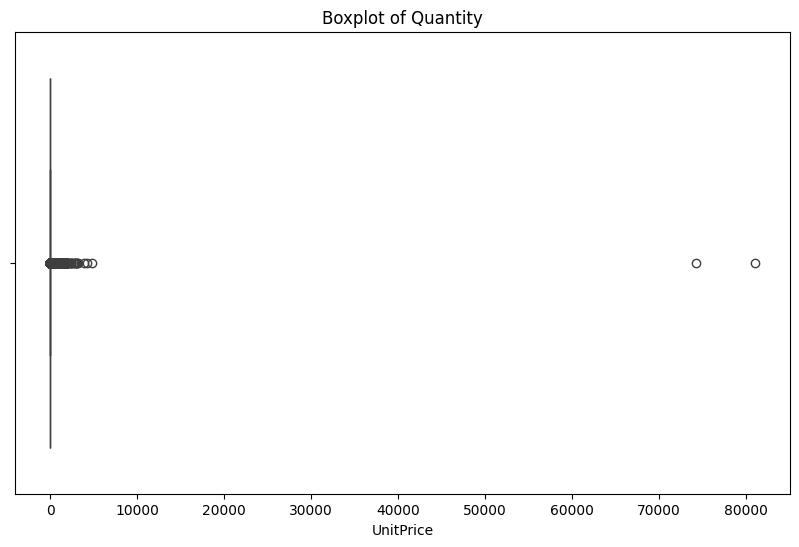

In [13]:
#Visualizing outliers of Quantity
plt.figure(figsize=(10, 6))
sns.boxplot(x=retail_csv['Quantity'])
plt.title('Boxplot of Quantity')
plt.xlabel('UnitPrice')
plt.show()

In [15]:
# retail_csv.to_csv("preprocessed_retail.csv",index = "False")

In [26]:
unitprice_percentile = retail_csv['UnitPrice'].quantile(0.73)
quantity_percentile = retail_csv['Quantity'].quantile(0.73)

retail_filtered = retail_csv[
    (retail_csv['UnitPrice'] <= unitprice_percentile) &
    (retail_csv['Quantity'] <= quantity_percentile)
]

retail_filtered.describe()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,230869.000000,230869.000000,230869.000000,230869.000000,230869,230869.000000,230869.000000,230869.000000
mean,9815.303510,1521.352152,2042.147551,6.036133,2011-07-12 20:30:53.052423680,1.616252,15388.184156,33.288965
min,0.000000,0.000000,0.000000,1.000000,2010-12-01 08:26:00,0.001000,12347.000000,0.000000
25%,4975.000000,891.000000,1308.000000,2.000000,2011-04-07 13:16:00,0.950000,14057.000000,35.000000
50%,10201.000000,1467.000000,1989.000000,6.000000,2011-08-02 14:04:00,1.650000,15356.000000,35.000000
75%,14603.000000,2054.000000,2909.000000,10.000000,2011-10-24 17:07:00,2.100000,16904.000000,35.000000
max,18531.000000,3664.000000,3876.000000,12.000000,2011-12-09 12:50:00,3.250000,18287.000000,36.000000
std,5414.335149,840.495054,1045.087970,4.285362,NaN,0.769493,1704.958502,6.033988


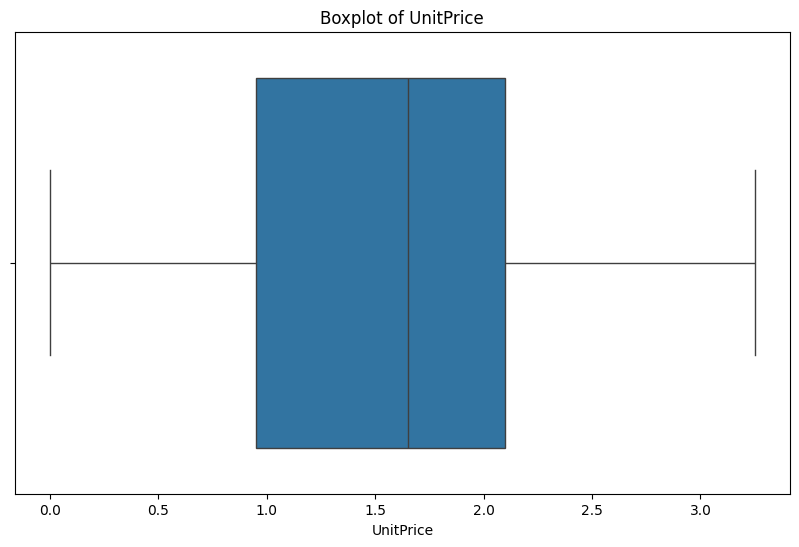

In [30]:
#Visualizing outliers of UnitPrice
plt.figure(figsize=(10, 6))
sns.boxplot(x=retail_filtered['UnitPrice'])
plt.title('Boxplot of UnitPrice')
plt.xlabel('UnitPrice')
plt.show()

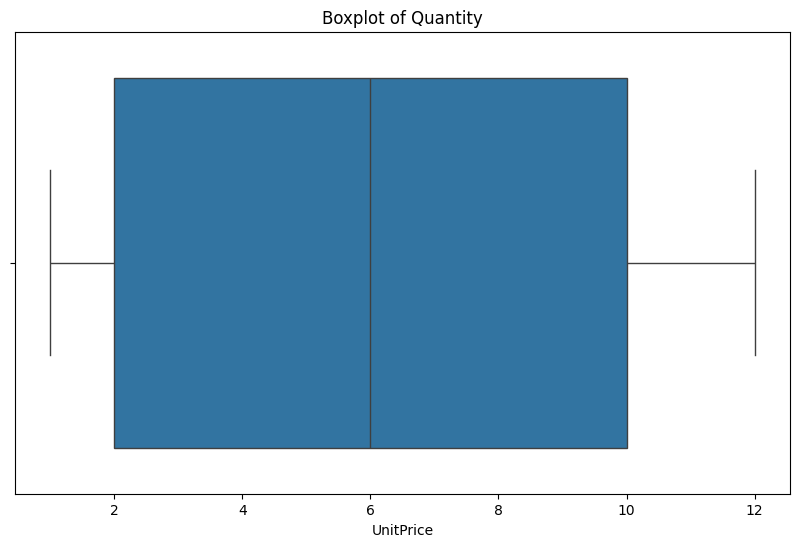

In [31]:
#Visualizing outliers of Quantity
plt.figure(figsize=(10, 6))
sns.boxplot(x=retail_filtered['Quantity'])
plt.title('Boxplot of Quantity')
plt.xlabel('UnitPrice')
plt.show()

In [34]:
#checking the dataframe after filtering
retail_filtered.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,3233,3698,6,2010-12-01 08:26:00,2.55,17850.0,35
2,0,2847,858,8,2010-12-01 08:26:00,2.75,17850.0,35
7,1,1486,1553,6,2010-12-01 08:28:00,1.85,17850.0,35
8,1,1485,1550,6,2010-12-01 08:28:00,1.85,17850.0,35
10,2,1594,2603,6,2010-12-01 08:34:00,2.10,13047.0,35


We don't need `InvoiceNo`,`CustomerID`,`Description` columns for the prediction. So, We will drop them

In [37]:
retail_filtered = retail_filtered.drop(columns=["InvoiceNo","CustomerID","Description"])
retail_filtered.head()

,StockCode,Quantity,InvoiceDate,UnitPrice,Country
0,3233,6,2010-12-01 08:26:00,2.55,35
2,2847,8,2010-12-01 08:26:00,2.75,35
7,1486,6,2010-12-01 08:28:00,1.85,35
8,1485,6,2010-12-01 08:28:00,1.85,35
10,1594,6,2010-12-01 08:34:00,2.10,35


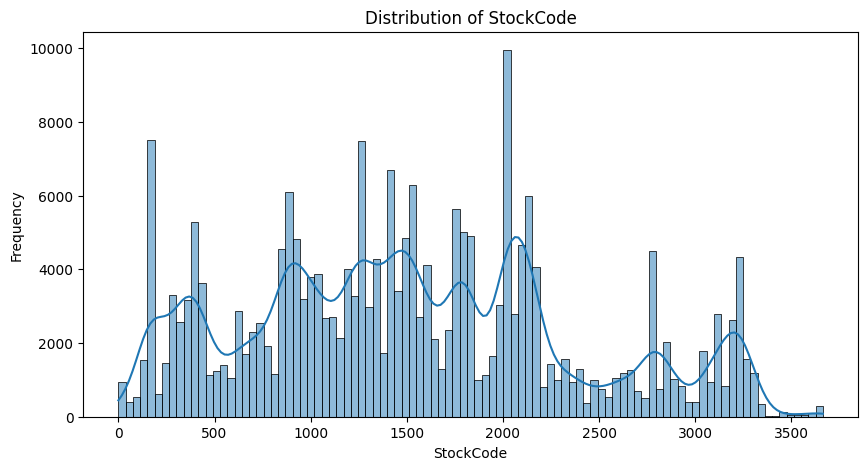

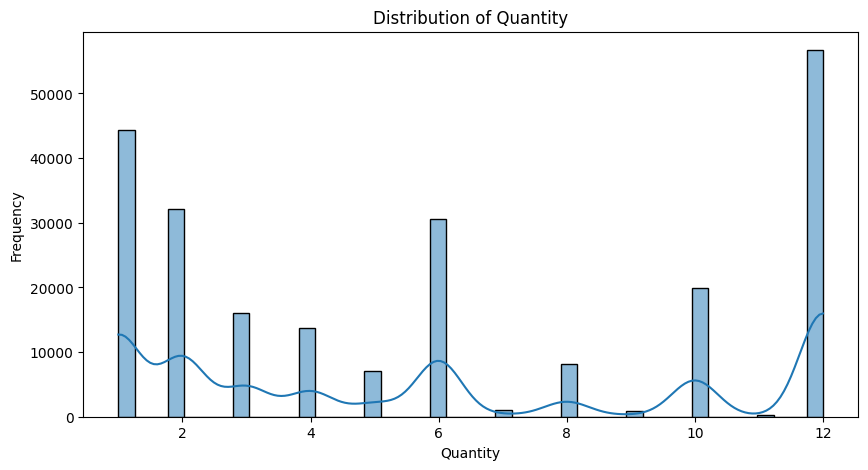

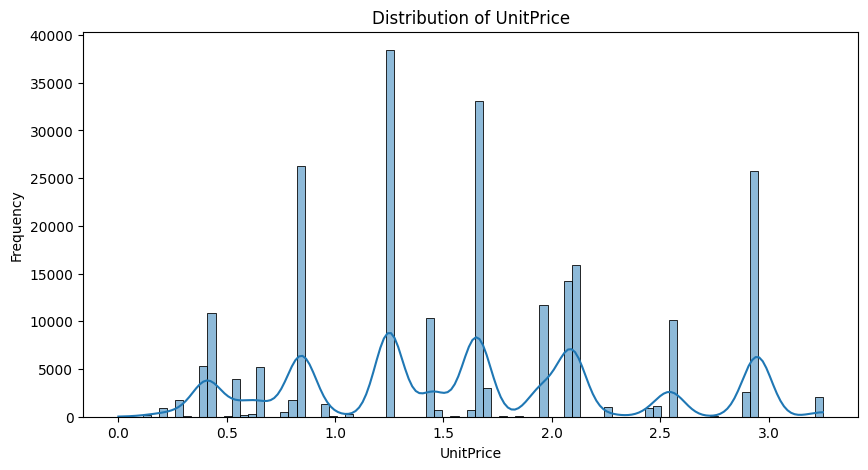

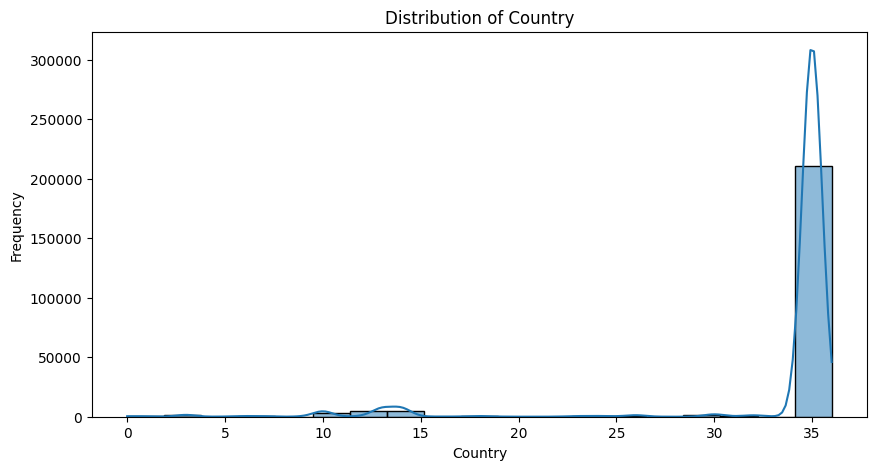

In [42]:
# Histograms for all numerical features
numerical_features = retail_filtered.select_dtypes(include=['int64', 'float64']).columns
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(retail_filtered[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


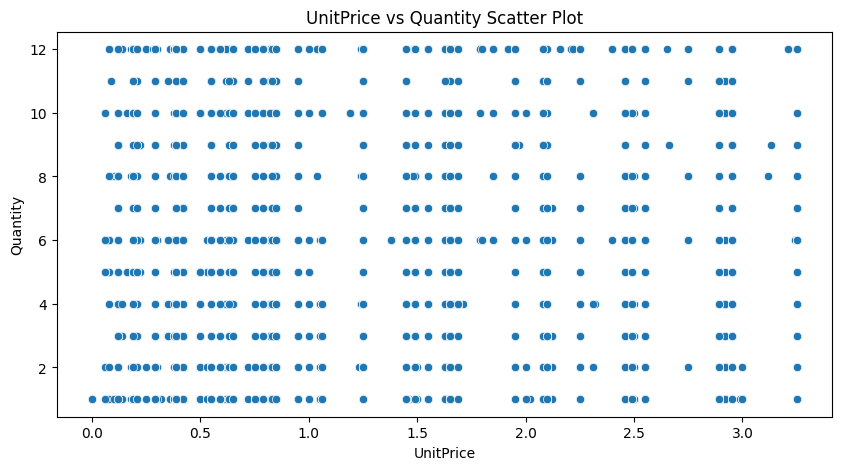

In [44]:
# Scatter plot for 'UnitPrice' vs 'Quantity'
plt.figure(figsize=(10, 5))
sns.scatterplot(x='UnitPrice', y='Quantity', data=retail_filtered)
plt.title('UnitPrice vs Quantity Scatter Plot')
plt.xlabel('UnitPrice')
plt.ylabel('Quantity')
plt.show()

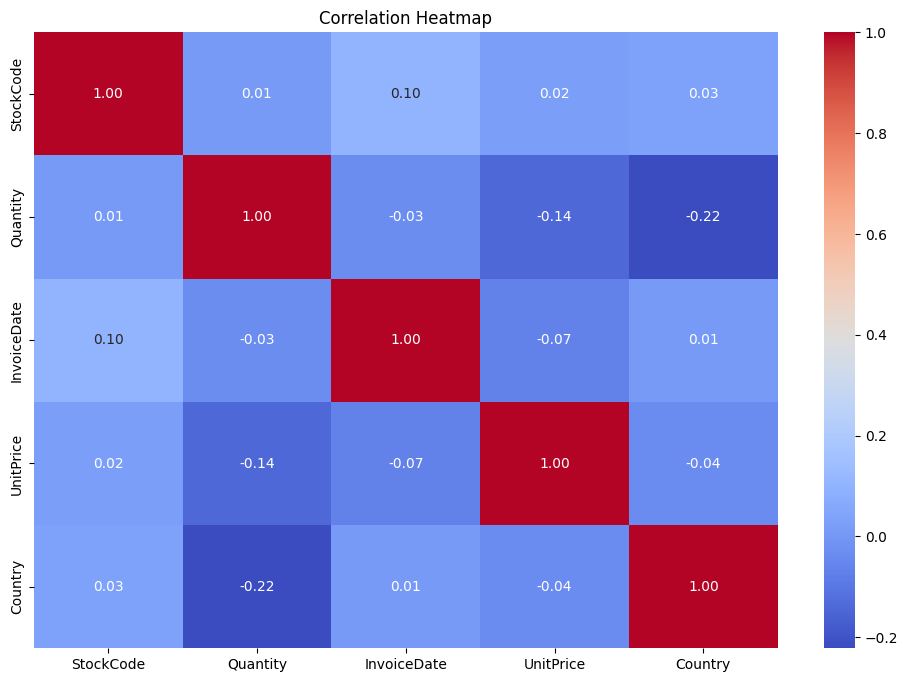

In [45]:
# Correlation heatmap
correlation_matrix = retail_filtered.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Building Model

Now we'll be making a random forest classifier from scratch

In [56]:
class RandomForestClassifier():
    
    def __init__(self, n_trees = 5, max_depth =5, min_samples_split = 2, n_feature = None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_sample_split = min_samples_split
        self.n_feature = n_feature
        self.trees = []
        
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split = self.min_sample_split,
                                n_features = self.n_feature)
            X_sample, y_sample = self._bootstrap_samples(X,y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            
    def predict(self, X):
        for tree in self.trees:
            predictions =np.array(tree.predict(X))
        tree_preds = np.swapaxes(predictions, 0,1)
        predictions = np.array([self._common_label(pred) for pred in tree_preds])
        return predictions
    
    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idx = np.random.choice(n_samples, n_samples, replace = True)
        return X[idx],y[idx]
    
    def _common_label(self, y):
        counter = Counter()
        most_common = counter.most_common(1)[0][0]
        return most_common

## Training and Evaluation

## Result Visualization